## Домашнее задание <a class='anchor' id='hw'>

1. Попробуйте обучить нейронную сеть U-Net на любом другом датасете. Напишите в комментариях к уроку, какого результата вы добились от нейросети, что помогло улучшить её точность?
2. Попробуйте свои силы в задаче Carvana на Kaggle: https://www.kaggle.com/c/carvana-image-masking-challenge/overview

In [1]:
# Импортируем необходимые библиотеки
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, concatenate, UpSampling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.callbacks import ModelCheckpoint
from PIL import Image
from tensorflow.keras.utils import plot_model
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.models import Model, Sequential
from keras.layers import (Activation, Input, MaxPooling2D, BatchNormalization, 
                          Conv2D, Conv2DTranspose, concatenate)
from tensorflow.keras.utils import plot_model

In [2]:
# возмём из лекции пример реализации модели U-Net с предобученной базой VGG16 в качестве энкодера.
def unet_pre_train(num_classes=32, input_shape=(128, 192, 3)):    
    pre_trained_model = VGG16(input_shape=input_shape, include_top=False, weights='imagenet')

    for layer in pre_trained_model.layers[:-5]:
        layer.trainable = False

    x = pre_trained_model.layers[13].output
    block_4_out = pre_trained_model.layers[10].output
    block_3_out = pre_trained_model.layers[6].output
    block_2_out = pre_trained_model.layers[3].output
    img_input = pre_trained_model.inputs
    print(block_4_out)
    print(block_3_out)
    print(block_2_out)
   
    # UP 1

    # добавили перенос из VGG16
    x = concatenate([x, block_4_out])
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)


    # UP 2
    x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # добавили перенос из VGG16
    x = concatenate([x, block_3_out])
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)


    # UP 3
    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # добавили перенос из VGG16
    x = concatenate([x, block_2_out])
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)


    # UP 4
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(num_classes, (3, 3), activation='softmax', padding='same')(x)

    model = Model(img_input, x)
    return model

Number of unique classes in masks: 2
KerasTensor(type_spec=TensorSpec(shape=(None, 16, 24, 256), dtype=tf.float32, name=None), name='block3_pool/MaxPool:0', description="created by layer 'block3_pool'")
KerasTensor(type_spec=TensorSpec(shape=(None, 32, 48, 128), dtype=tf.float32, name=None), name='block2_pool/MaxPool:0', description="created by layer 'block2_pool'")
KerasTensor(type_spec=TensorSpec(shape=(None, 64, 96, 64), dtype=tf.float32, name=None), name='block1_pool/MaxPool:0', description="created by layer 'block1_pool'")


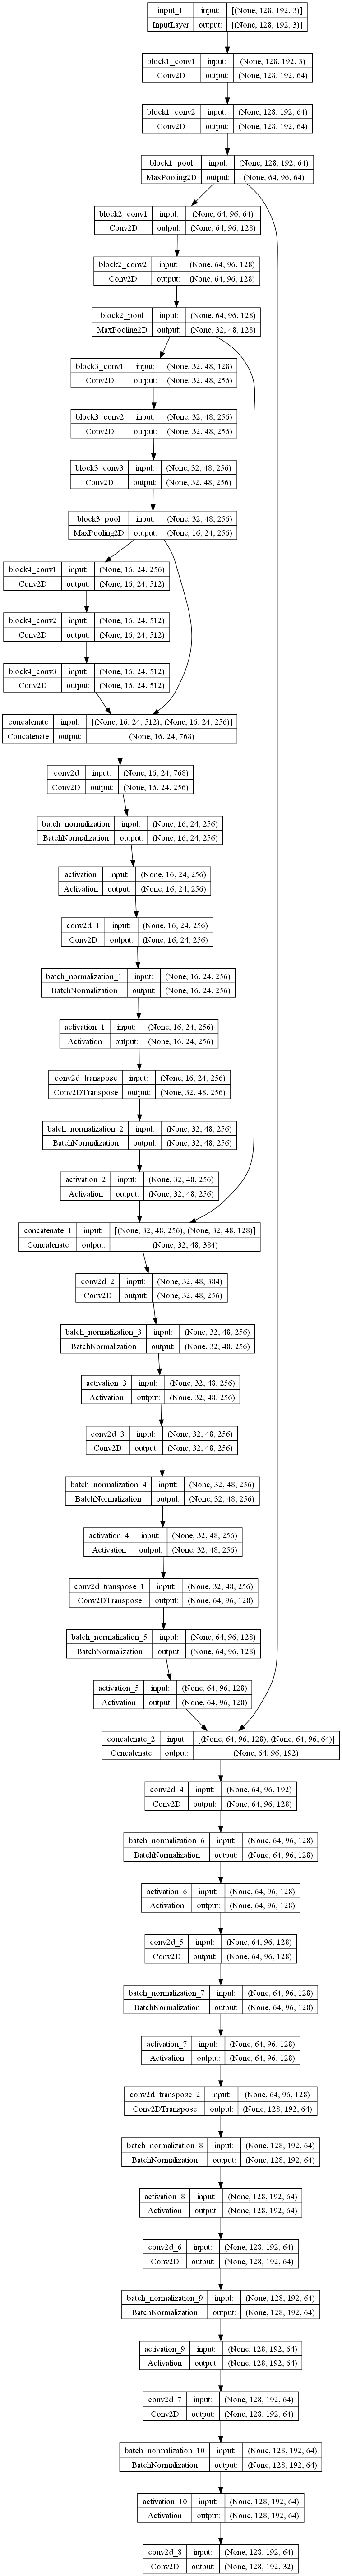

In [3]:
# Загрузим файл CSV с метками классов
class_dict = pd.read_csv('../Lesson_6.Segmentation/CamVid/class_dict.csv')

# Путь к каталогам данных
path_train = '../Lesson_6.Segmentation/CamVid/train/'
path_train_labels = '../Lesson_6.Segmentation/CamVid/train_labels/'
path_test = '../Lesson_6.Segmentation/CamVid/test/'
path_test_labels = '../Lesson_6.Segmentation/CamVid/test_labels/'
path_val = '../Lesson_6.Segmentation/CamVid/val/'
path_val_labels = '../Lesson_6.Segmentation/CamVid/val_labels/'

# Список путей к обучающим образам
train_images_paths = list(Path(path_train).iterdir())

# Рассчитаем новый размер изображения
single_image = Image.open(train_images_paths[0])
image_size = (int(single_image.size[0] / 2), single_image.size[1])

# Загрузим пути обучения, тестирования и проверки изображений и масок
train_imgs_paths = list(sorted(Path(path_train).iterdir()))
train_masks_paths = list(sorted(Path(path_train_labels).iterdir()))
test_imgs_paths = list(sorted(Path(path_test).iterdir()))
test_masks_paths = list(sorted(Path(path_test_labels).iterdir()))
val_imgs_paths = list(sorted(Path(path_val).iterdir()))
val_masks_paths = list(sorted(Path(path_val_labels).iterdir()))

# Установим размер изображения и количество классов
image_height, image_width = 128, 192
num_classes = len(class_dict)

# Функция чтения и предварительной обработки изображений и масок
def read_and_preprocess_image(image_path, label_path, image_height, image_width):
    # Read the image
    image = cv2.imread(str(image_path))
    # Resize the image
    image = cv2.resize(image, (image_height, image_width))
    # Normalize pixel values
    image = image / 255.0
    
    # Прочтите маску
    label = cv2.imread(str(label_path), cv2.IMREAD_GRAYSCALE)
    # Изменить размер маски
    label = cv2.resize(label, (image_height, image_width))
    # Преобразование значений маски в двоичные (0 или 1)
    label = (label > 0).astype(int)
    
    return image, label

# Списки для хранения изображений и масок
train_images = []
train_masks = []
test_images = []
test_masks = []
val_images = []
val_masks = []

# Чтение и предварительная обработка обучающих изображений и масок
for i_img, i_mask in zip(train_imgs_paths, train_masks_paths):
    img, mask = read_and_preprocess_image(i_img, i_mask, image_height, image_width)
    train_images.append(img)
    train_masks.append(mask)

# Чтение и предварительная обработка тестовых изображений и масок
for i_img, i_mask in zip(test_imgs_paths, test_masks_paths):
    img, mask = read_and_preprocess_image(i_img, i_mask, image_height, image_width)
    test_images.append(img)
    test_masks.append(mask)

# Чтение и предварительная обработка проверочных изображений и масок
for i_img, i_mask in zip(val_imgs_paths, val_masks_paths):
    img, mask = read_and_preprocess_image(i_img, i_mask, image_height, image_width)
    val_images.append(img)
    val_masks.append(mask)

# Преобразование списков изображений и масок в массивы numpy.
train_images = np.array(train_images)
train_masks = np.array(train_masks)
test_images = np.array(test_images)
test_masks = np.array(test_masks)
val_images = np.array(val_images)
val_masks = np.array(val_masks)

# Загрузим one-hot (бинарное) кодирование. 
from tensorflow.keras.utils import to_categorical

# Проверим количество уникальных классов в масках.
num_unique_classes = len(np.unique(train_masks))
print("Number of unique classes in masks:", num_unique_classes)

# Обновим переменную num_classes.
num_classes = num_unique_classes

# Выполним one-hot кодирование меток классов для масок.
train_masks = to_categorical(train_masks, num_classes=num_classes)
test_masks = to_categorical(test_masks, num_classes=num_classes)
val_masks = to_categorical(val_masks, num_classes=num_classes)

# Создадим модель.
model = unet_pre_train(32, (128, 192, 3))

# Построим архитектуру модели и сохраним ее в файл.
plot_model(model, to_file='model.png', show_shapes=True)


In [38]:
# Обновим входной формат, чтобы он соответствовала размеру предварительно обработанного изображения.
input_shape = (image_width, image_height, 3)
input_shape

(192, 128, 3)

In [39]:
# Воссоздадим модель с обновленной входной формой
model = unet_pre_train(num_classes=num_classes, input_shape=input_shape)

KerasTensor(type_spec=TensorSpec(shape=(None, 24, 16, 256), dtype=tf.float32, name=None), name='block3_pool/MaxPool:0', description="created by layer 'block3_pool'")
KerasTensor(type_spec=TensorSpec(shape=(None, 48, 32, 128), dtype=tf.float32, name=None), name='block2_pool/MaxPool:0', description="created by layer 'block2_pool'")
KerasTensor(type_spec=TensorSpec(shape=(None, 96, 64, 64), dtype=tf.float32, name=None), name='block1_pool/MaxPool:0', description="created by layer 'block1_pool'")


In [40]:
# Скомпилируем модель
model.compile(optimizer=Adam(learning_rate=1e-4), loss=binary_crossentropy, metrics=[MeanIoU(num_classes=num_classes)])

In [28]:
# Установим количество эпох и размер пакета для обучения
epochs = 20
batch_size = 16

# Обучим модель
history = model.fit(train_images, train_masks, batch_size=batch_size, epochs=epochs, validation_data=(val_images, val_masks))

Epoch 1/20
24/24 [==============================] - 165s 7s/step - loss: 0.7845 - mean_io_u_2: 0.2500 - val_loss: 1.3832 - val_mean_io_u_2: 0.2500
Epoch 2/20
24/24 [==============================] - 163s 7s/step - loss: 0.3881 - mean_io_u_2: 0.2500 - val_loss: 1.4612 - val_mean_io_u_2: 0.2495
Epoch 3/20
24/24 [==============================] - 163s 7s/step - loss: 0.2581 - mean_io_u_2: 0.2500 - val_loss: 0.7090 - val_mean_io_u_2: 0.2500
Epoch 4/20
24/24 [==============================] - 163s 7s/step - loss: 0.2043 - mean_io_u_2: 0.2500 - val_loss: 0.5797 - val_mean_io_u_2: 0.2500
Epoch 5/20
24/24 [==============================] - 169s 7s/step - loss: 0.1756 - mean_io_u_2: 0.2500 - val_loss: 0.4935 - val_mean_io_u_2: 0.2500
Epoch 6/20
24/24 [==============================] - 170s 7s/step - loss: 0.1554 - mean_io_u_2: 0.2500 - val_loss: 0.4286 - val_mean_io_u_2: 0.2500
Epoch 7/20
24/24 [==============================] - 172s 7s/step - loss: 0.1419 - mean_io_u_2: 0.2500 - val_loss: 0.39

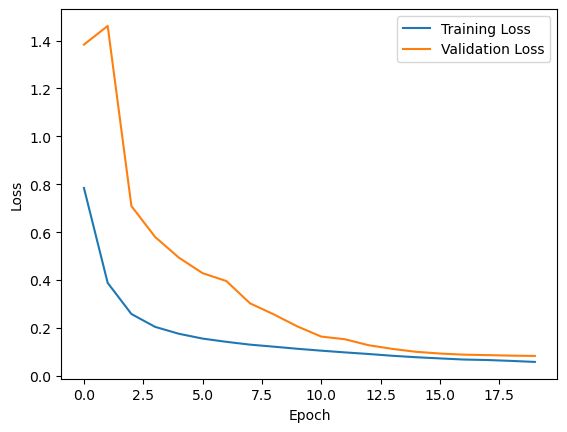

In [30]:
# Построим график потерь при обучении и проверке.
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [34]:
# Теперь мы можем выполнить предсказания для тестовых изображений, используя обученную модель.
predictions = model.predict(test_images)

8/8 [==============================] - 35s 4s/step


**Оценим насколько хорошо обученная модель работает**

In [32]:
test_loss, test_accuracy = model.evaluate(test_images, test_masks)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')


8/8 [==============================] - 37s 5s/step - loss: 0.1052 - mean_io_u_2: 0.2500
Test Loss: 0.10519164800643921, Test Accuracy: 0.25000205636024475


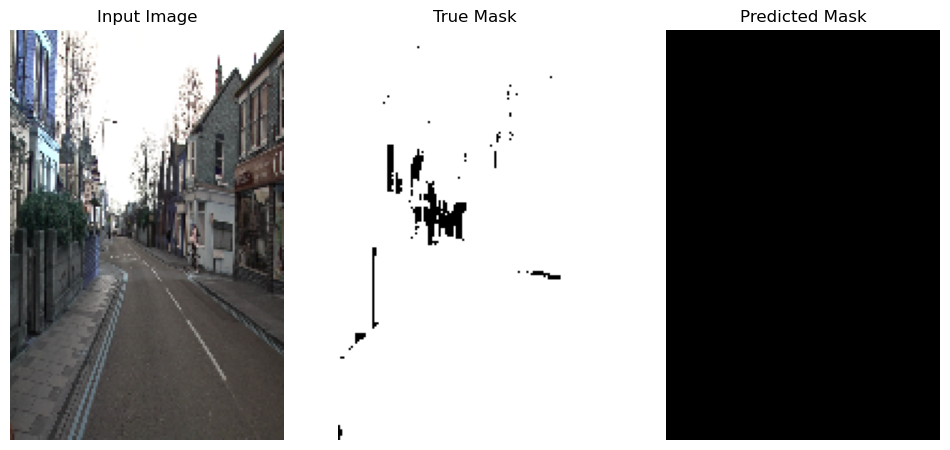

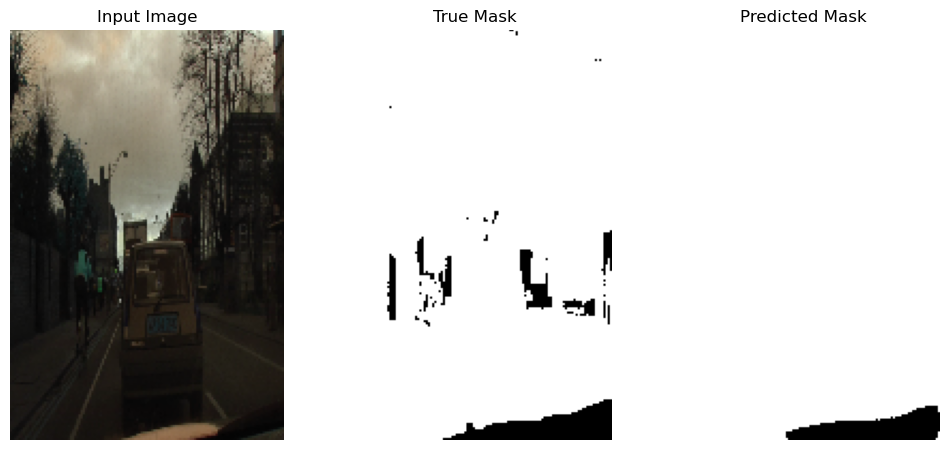

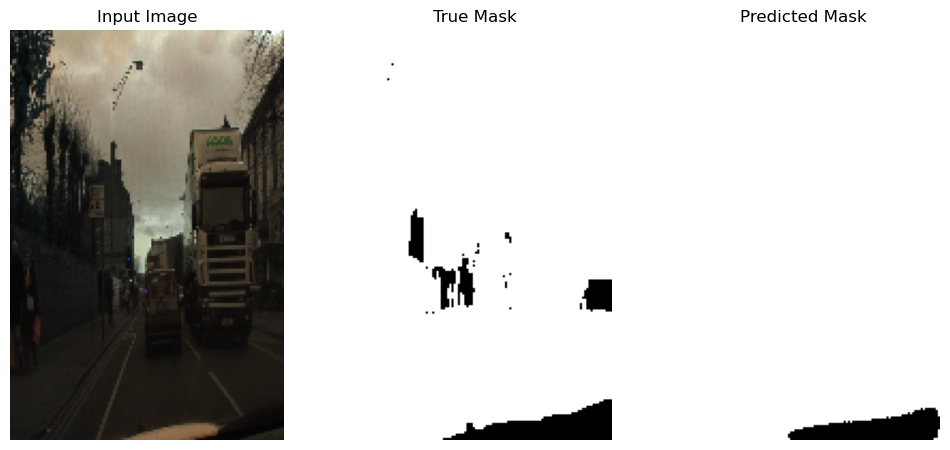

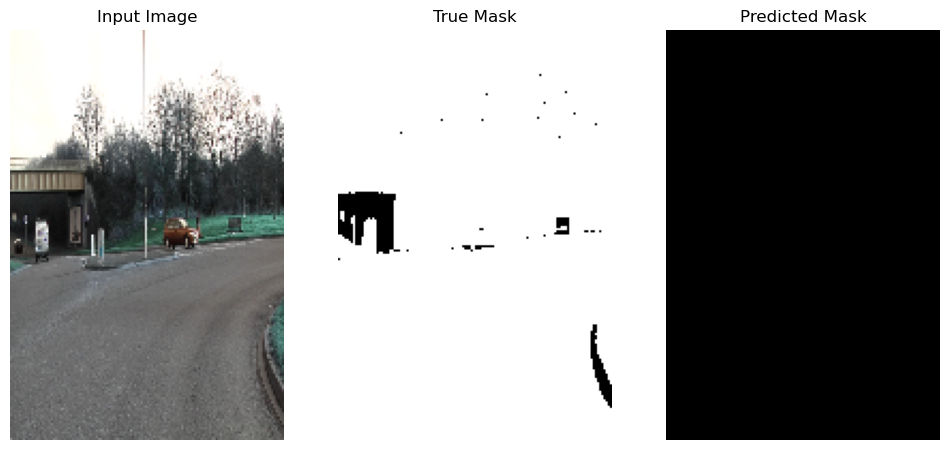

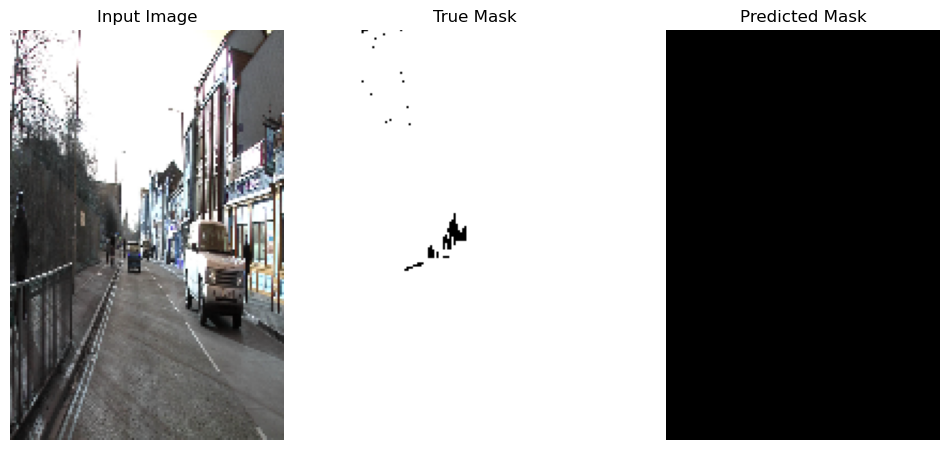

In [36]:
# Выберим случайные индексы из тестового набора
random_indices = random.sample(range(len(test_images)), 5)

# Визуализируем исходные изображения, маски и прогнозы
for idx in random_indices:
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 3, 1)
    plt.imshow(test_images[idx])
    plt.title('Input Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(np.argmax(test_masks[idx], axis=-1), cmap='gray')
    plt.title('True Mask')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(np.argmax(predictions[idx], axis=-1), cmap='gray')
    plt.title('Predicted Mask')
    plt.axis('off')

    plt.show()


In [37]:
# оценим качество сегментации на стандартных метриках, таких как Intersection over Union (IoU) или Dice Coefficient.
from sklearn.metrics import jaccard_score, f1_score

# Посчитайте IoU и F1-score для прогнозов и истинных масок
iou_scores = [jaccard_score(np.argmax(test_masks[i], axis=-1).flatten(), np.argmax(predictions[i], axis=-1).flatten()) for i in range(len(test_images))]
f1_scores = [f1_score(np.argmax(test_masks[i], axis=-1).flatten(), np.argmax(predictions[i], axis=-1).flatten()) for i in range(len(test_images))]

# Среднее значение метрик по всем изображениям
mean_iou = np.mean(iou_scores)
mean_f1 = np.mean(f1_scores)

print(f'Mean IoU: {mean_iou}, Mean F1-score: {mean_f1}')


Mean IoU: 0.9761790701872889, Mean F1-score: 0.9877707725058275
